In [1]:
from pyscf import gto,scf
from pyscf.geomopt.berny_solver import optimize
import numpy as np
from alch_deriv import alch_deriv
import matplotlib.pyplot as plt
def DeltaV(mol,dL):
    mol.set_rinv_orig_(mol.atom_coords()[dL[0][0]])
    dV=mol.intor('int1e_rinv')*dL[1][0]
    for i in range(1,len(dL[0])): 
        mol.set_rinv_orig_(mol.atom_coords()[dL[0][i]])
        dV+=mol.intor('int1e_rinv')*dL[1][i]
    return -dV.reshape((dV.shape[0],dV.shape[1]))
#ao_div=mol0.aoslice_by_atom()[:,-2:]
#pt=ao_div[1][0]
def change_order(P0,pt):  # to rotate the idx of the carbon atoms
    Pn=np.zeros_like(P0)
    Pn[:-pt,:-pt]=P0[pt:,pt:]
    Pn[-pt:,-pt:]=P0[:pt,:pt]
    Pn[:-pt,-pt:]=P0[pt:,:pt]
    Pn[-pt:,:-pt]=P0[:pt,pt:]
    return Pn

In [2]:
benz_atom="""C 0.0 2.6196127020137916 0.0;
H 0.0 4.652157753665769 0.0;
C 2.268651148020338 1.309806351006896 0.0;
H 4.028886797087305 2.326078876832885 0.0;
C 2.2686511480203384 -1.3098063510068951 0.0;
H 4.028886797087305 -2.3260788768328835 0.0;
C 3.208100310526939e-16 -2.6196127020137916 0.0;
H 5.697250102155325e-16 -4.652157753665769 0.0;
C -2.2686511480203375 -1.309806351006897 0.0;
H -4.028886797087303 -2.3260788768328866 0.0;
C -2.2686511480203393 1.309806351006894 0.0;
H -4.028886797087306 2.3260788768328813 0.0
"""
mol_benz = gto.M(atom=benz_atom, basis='6-31G',unit='bohr')

In [3]:
#mf_benz=scf.RHF(mol_benz)
#optimize(mf_benz)
pass

In [4]:
benz_atom_opt=""" C   0.000000   1.388317  0.000000;  
   H  -0.000000   2.461627  -0.000000  ;
   C   1.202318   0.694159   0.000000  ;
   H   2.131832   1.230814  -0.000000  ;
   C   1.202318  -0.694159  -0.000000  ;
   H   2.131832  -1.230814  -0.000000  ;
   C   0.000000  -1.388317   0.000000  ;
   H   0.000000  -2.461627   0.000000  ;
   C  -1.202318  -0.694159  -0.000000  ;
   H  -2.131832  -1.230814  -0.000000  ;
   C  -1.202318   0.694159   0.000000  ;
   H  -2.131832   1.230814  -0.000000  
"""
mol_benz = gto.M(atom=benz_atom_opt, basis='6-31G') #angstroms not unir
mf_benz=scf.RHF(mol_benz)
mf_benz.scf()

converged SCF energy = -230.624474947016


-230.62447494701618

In [5]:
P0=mf_benz.make_rdm1()
print(mol_benz.atom_charges())

[6 1 6 1 6 1 6 1 6 1 6 1]


In [6]:
dP1,dP2,dP3=alch_deriv(mf_benz,dL=[[2,4],[1,-1]])[1],alch_deriv(mf_benz,dL=[[2],[1]])[1],alch_deriv(mf_benz,dL=[[4],[-1]])[1]

[[2, 4], [1, -1]]
[[2], [1]]
[[4], [-1]]


In [7]:
np.allclose(dP1,dP2+dP3)

True

In [8]:
np.linalg.norm(dP1)

0.002297111295432446

In [9]:
np.linalg.norm(dP2)

0.0017096521205838841

In [10]:
np.linalg.norm(dP3)

0.0017096521205836037

In [11]:
np.linalg.norm(dP2+dP3)

0.002297099217332035

In [12]:
np.linalg.norm(dP1-dP2-dP3)

6.720900829931674e-08

In [13]:
#easy to get derivatives 

In [14]:
dP2.dot(DeltaV(mol_benz,[[2],[1]])).trace()*1000

-1.3001730133412313

In [15]:
np.einsum('ij,ij',P0,DeltaV(mol_benz,[[2],[1]]))

-24.532275644715583

In [16]:
P0.dot(DeltaV(mol_benz,[[2],[1]])).trace()

-24.53227564471558

In [17]:
np.einsum('ij,ij',P0,DeltaV(mol_benz,[[2,4],[1,-1]]))

2.9596117223640306e-14

## Build the alchemical Hessian Matrix
$$ H_{\alpha\beta} = \frac{\partial^2 E_{electronic}}{\partial Z_\alpha \partial Z_\beta}= \frac{\partial}{\partial Z_\beta}
\sum_{ij} P_{ij}\frac{\partial V_{ij}}{\partial Z_\alpha}
$$ 
$$=\sum_{ij} \frac{\partial P_{ij}}{\partial Z_\beta}\frac{\partial V_{ij}}{\partial Z_\alpha}+
\sum_{ij} P_{ij}\frac{\partial^2 V_{ij}}{\partial Z_\alpha \partial Z_\beta}
$$
The second term is zero since $V$ contains only first order terms in nuclear charges.
Therefore:
$$ H_{\alpha\beta} = \sum_{ij} \frac{\partial P_{ij}}{\partial Z_\beta}\frac{\partial V_{ij}}{\partial Z_\alpha}
$$

In [18]:
#alchemical hessian on the coordinates of the charges of the C atoms 
H_alch=np.zeros((6,6))
for i in range(6):
    for j in range(6):
        H_alch[i,j]=np.einsum('ij,ij',  alch_deriv(mf_benz,dL=[[2*i],[1]])[1] ,DeltaV(mol_benz,[[2*j],[1]]) )*1000  #idx in molecule are 0,2,4,...

[[0], [1]]
[[0], [1]]
[[0], [1]]
[[0], [1]]
[[0], [1]]
[[0], [1]]
[[2], [1]]
[[2], [1]]
[[2], [1]]
[[2], [1]]
[[2], [1]]
[[2], [1]]
[[4], [1]]
[[4], [1]]
[[4], [1]]
[[4], [1]]
[[4], [1]]
[[4], [1]]
[[6], [1]]
[[6], [1]]
[[6], [1]]
[[6], [1]]
[[6], [1]]
[[6], [1]]
[[8], [1]]
[[8], [1]]
[[8], [1]]
[[8], [1]]
[[8], [1]]
[[8], [1]]
[[10], [1]]
[[10], [1]]
[[10], [1]]
[[10], [1]]
[[10], [1]]
[[10], [1]]


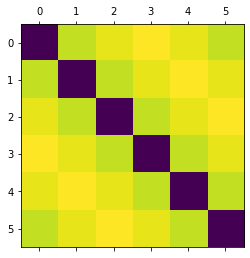

In [19]:
plt.matshow(H_alch)

In [20]:
np.round(np.linalg.eig(H_alch)[0],decimals=2),np.round(np.linalg.eig(H_alch)[1],decimals=2)

(array([-1.46, -1.19, -1.17, -1.41, -1.41, -1.17]),
 array([[-0.41, -0.41,  0.58, -0.58, -0.  ,  0.  ],
        [-0.41,  0.41, -0.29, -0.29, -0.5 , -0.5 ],
        [-0.41, -0.41, -0.29,  0.29, -0.5 ,  0.5 ],
        [-0.41,  0.41,  0.58,  0.58,  0.  ,  0.  ],
        [-0.41, -0.41, -0.29,  0.29,  0.5 , -0.5 ],
        [-0.41,  0.41, -0.29, -0.29,  0.5 ,  0.5 ]]))

In [21]:
np.round(H_alch,decimals=2)

array([[-1.3 , -0.09, -0.01,  0.04, -0.01, -0.09],
       [-0.09, -1.3 , -0.09, -0.01,  0.04, -0.01],
       [-0.01, -0.09, -1.3 , -0.09, -0.01,  0.04],
       [ 0.04, -0.01, -0.09, -1.3 , -0.09, -0.01],
       [-0.01,  0.04, -0.01, -0.09, -1.3 , -0.09],
       [-0.09, -0.01,  0.04, -0.01, -0.09, -1.3 ]])

In [22]:
np.array([1,0,-1,0,0,0]).dot(H_alch.dot(np.array([1,0,-1,0,0,0])))

-2.5783547285682493

In [23]:
H_alch@(np.array([1,0,-1,0,0,0]))

array([-1.28917725e+00, -3.05799227e-07,  1.28917748e+00,  1.21986334e-01,
        4.26941859e-08, -1.21986552e-01])

In [24]:
(np.array([1,0,-1,0,0,0]))@H_alch@(np.array([1,0,-1,0,0,0])) #H11-H13+H33-H31 #vai a vedere il termine più alto fuori diag

-2.5783547285682493

In [25]:
def bmatrix(a):
    """Returns a LaTeX bmatrix

    :a: numpy array
    :returns: LaTeX bmatrix as a string
    """
    if len(a.shape) > 2:
        raise ValueError('bmatrix can at most display two dimensions')
    lines = str(a).replace('[', '').replace(']', '').splitlines()
    rv = [r'\begin{bmatrix}']
    rv += ['  ' + ' & '.join(l.split()) + r'\\' for l in lines]
    rv +=  [r'\end{bmatrix}']
    return '\n'.join(rv)

In [28]:
print(bmatrix(np.round(H_alch,decimals=2)))

\begin{bmatrix}
  -1.3 & -0.09 & -0.01 & 0.04 & -0.01 & -0.09\\
  -0.09 & -1.3 & -0.09 & -0.01 & 0.04 & -0.01\\
  -0.01 & -0.09 & -1.3 & -0.09 & -0.01 & 0.04\\
  0.04 & -0.01 & -0.09 & -1.3 & -0.09 & -0.01\\
  -0.01 & 0.04 & -0.01 & -0.09 & -1.3 & -0.09\\
  -0.09 & -0.01 & 0.04 & -0.01 & -0.09 & -1.3\\
\end{bmatrix}
